# Powertrain for UAV

In [77]:
%matplotlib inline
from scipy.integrate import quad, ode, odeint
from scipy import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv

nsteps = lambda x: np.linspace(0, x, 100)


### Battery profile

In [276]:
def get_poly(curve, pwr=5):
    """
        @brief: gets the coefficients for a polynomial approximation of given curve
        
        @input:
            curve: the curve as an np.array
            pwr: power of the curve to fit, default=5
        
        @output:
            an np.array of length(pwr) representing the coefficients of the curve
    """ 
    x_poly = np.arange(0, len(curve))
    y_poly = np.polyfit(x_poly, curve, pwr)
    return y_poly

def get_battery_curves(soc_ocv_file, R0_degradation_file, Q_degradation_file):
    """
        @brief: gets the degradation profile (predefined curves) for the battery
        
        @input:
            soc_ocv_file: a csv file containing the soc_ocv relationship as a column vector
            R0_degradation_file: a csv file containing the R0 degradation curve as a column vector
            Q_degradation_file: a csv file containing the Q degradation curve as a column vector
        
        @output:
            a dictionary mapping of degradation curve coefficients with ["z_coef", "r0_coef", "q_coef", "EOL"] keys
    """    
    soc_ocv = []
    R0_degradation = []
    Q_degradation = []
    
    with open(soc_ocv_file, newline='') as f:
        soc_ocv = list(csv.reader(f))
    soc_ocv = np.asarray(soc_ocv).astype(np.float)
    
    with open(R0_degradation_file, newline='') as f:
        R0_degradation = list(csv.reader(f))
    R0_degradation = np.asarray(R0_degradation).astype(np.float)
    
    with open(Q_degradation_file, newline='') as f:
        Q_degradation = list(csv.reader(f))
    Q_degradation = np.asarray(Q_degradation).astype(np.float)
    
    z_coef = get_poly(soc_ocv)
    r0_coef = get_poly(R0_degradation)
    q_coef = get_poly(Q_degradation)
    eol = len(Q_degradation)
    
    return {"z_coef": z_coef, "r0_coef": r0_coef, "q_coef": q_coef, "eol": eol, "soc_ocv": soc_ocv}



### Base Battery Cell

In [287]:
class Battery:
    def __init__(self, *args, **kwargs):
        if(len(kwargs) == 0):
            self.z_coef = np.zeros((1,1))
            self.r0_coef = np.zeros((1,1))
            self.q_coef = np.zeros((1,1))
            self.eod = 1
            self.eol = 1
        else:
            self.z_coef = kwargs["z_coef"]
            self.r0_coef = kwargs["r0_coef"]
            self.q_coef = kwargs["q_coef"]
            self.eol = kwargs["eol"]
        self.z = 1.0
        self.Ir = 0
        self.h = 0
        self.M0 = .0019
        self.M = .0092
        self.R0 = .0112
        self.R = 2.83e-4
        self.Q = 3.8695
        self.n = .9987
        self.G = 163.4413
        self.v0 = 4.2
        self.eod = 3.04
        self.RC = 3.6572
        self.ocv = self.v0
        
    def get_ocv(self):
        raise NotImplementedError
    
    def step(self, dt, current):
        raise NotImplementedError
        
    def reset(self):
        self.z = 1.0
        self.ocv = self.v0
        self.Ir = 0
        self.h = 0
        

### The Continuous Battery Cell

In [278]:
class ContinuousBatteryCell(Battery):
    def __init__(self, *args, **kwargs):
        super(ContinuousBatteryCell, self).__init__(*args, **kwargs)
        print("continuous battery cell")
        
    def get_ocv(self):
        return np.polyval(self.z_coef, self.z*100.0)
    
    def step(self, dt, current):
        RC = np.exp(-dt/abs(self.RC))
        H = np.exp(-abs(self.n*current*self.G*dt/(3600*self.Q)))
        self.Ir = RC*self.Ir + (1-RC)*current
        self.h = H*self.h + (H-1)*np.sign(current)
        self.z = self.z - self.n*current/3600/self.Q
        self.ocv = self.get_ocv() + self.M*self.h + self.M0*np.sign(current) - self.R*self.Ir - self.R0*current
        

In [282]:
battery_coefficients = get_battery_curves('soc_ocv.csv', 'R0_degradation.csv', 'Q_degradation.csv')


continuous battery cell
[4.22139702]


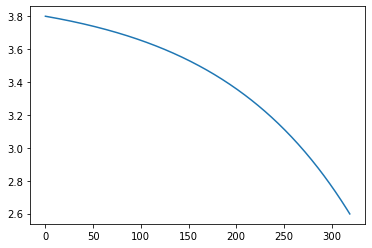

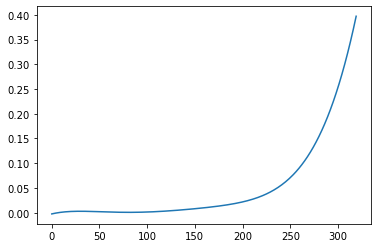

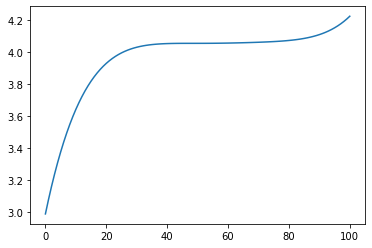

In [279]:
cbcell = ContinuousBatteryCell(**battery_coefficients)
print(cbcell.get_ocv())
plt.plot(np.arange(0, cbcell.eol), np.polyval(cbcell.q_coef, np.arange(0, cbcell.eol)))
plt.show()
plt.plot(np.arange(0, cbcell.eol), np.polyval(cbcell.r0_coef, np.arange(0, cbcell.eol)))
plt.show()
plt.plot(np.arange(0, 101), np.polyval(cbcell.z_coef, np.arange(0, 101)))
plt.show()

### The Discrete Battery Cell

In [283]:
class DiscreteBatteryCell(Battery):
    def __init__(self, *args, **kwargs):
        super(DiscreteBatteryCell, self).__init__(*args, **kwargs)
        self.soc_ocv = kwargs['soc_ocv']
        
    def get_ocv(self):
        if(self.z < 0.0):
            self.z = 0
        elif(self.z > 1.0):
            self.z = 1.0
        idx = int(np.ceil(self.z*100))
        if(idx > 101):
            idx = 101
        elif(idx < 1):
            idx = 1
        return self.soc_ocv[idx]
        
    def step(self, dt, current):
        RC = np.exp(-dt/abs(self.RC))
        H = np.exp(-abs(self.n*current*self.G*dt/(3600*self.Q)))
        self.Ir = RC*self.Ir + (1-RC)*current
        self.h = H*self.h + (H-1)*np.sign(current)
        self.z = self.z - self.n*current/3600/self.Q
        self.ocv = self.get_ocv() + self.M*self.h + self.M0*np.sign(current) - self.R*self.Ir - self.R0*current
        

4.2


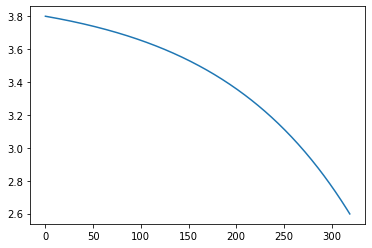

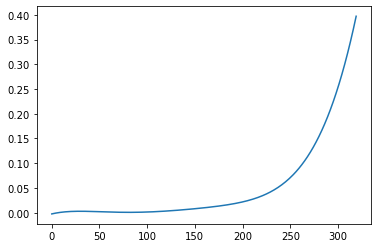

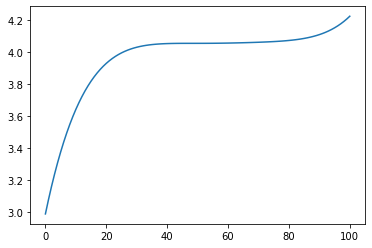

In [286]:
dbcell = DiscreteBatteryCell(**battery_coefficients)
print(dbcell.get_ocv()[0])
plt.plot(np.arange(0, dbcell.eol), np.polyval(dbcell.q_coef, np.arange(0, dbcell.eol)))
plt.show()
plt.plot(np.arange(0, dbcell.eol), np.polyval(dbcell.r0_coef, np.arange(0, dbcell.eol)))
plt.show()
plt.plot(np.arange(0, 101), np.polyval(dbcell.z_coef, np.arange(0, 101)))
plt.show()

### The battery
- Something is off with the battery, need to double check the series / parallel configuration

In [ ]:
class DiscreteBattery:
    def __init__(self, cells: DiscreteBatteryCell, wiring):
        self.cells = cells
        self.wiring = wiring
        self.v0 = self.cells[0].v0 if wiring == "parallel" else sum(cell.v0 for cell in self.cells)
        self.v0 = round(self.v0, 3)
        self.z = 1.0
        self.ocv = self.v0
        self.eod = self.cells[0].eod if wiring == "parallel" else sum(cell.eod for cell in celf.cells)
        
    def step(self, dt, current):
        if(self.wiring == "parallel"):
            for cell in self.cells:
                cell.step(dt, current)
            self.z = sum(cell.z for cell in self.cells) / 3
            self.ocv = sum(cell.ocv for cell in self.cells) / 3
            

### test the cells and battery

In [ ]:
cells = []
for i in range(0,3):
    cells.append(DiscreteBatteryCell(**battery_curves))
battery = DiscreteBattery(cells, "parallel")
cell = DiscreteBatteryCell(**battery_curves)

#### simulate the cell
- dt = 1 second, current = 3.8695
- the cell capacity is 3.8695 mAh, so, i should be ~3600 
- the cell asymptotically approaches the eod, so have to stop slightly above

In [292]:
dbcell.reset()
i = 0
while(dbcell.ocv > (dbcell.eod * 1.005)):
    dbcell.step(1, 3.8695)
    i += 1
print(dbcell.ocv)
print(i)

[3.04926653]
3569


### integration learning
quad(f, a, b)
- computes integral of f from a to b
- returns value, error estimate  

dblquad(f, a, b, gx, hx)
- computes integral of f from a to b on gy to hy
- returns value, error estimate


In [ ]:
%matplotlib inline
from scipy.integrate import quad, ode, odeint
from scipy import random
#quad??

example: integrate 3x^2 + 1 dx from 0 to 1

In [ ]:
def f(x):
    return 3.0*x**2 + 1

I = quad(f, 0, 1)[0]
print(I)

def dxdt(t, x):
    return  -x / 10

integrator = ode(dxdt).set_integrator('vode', nsteps=500, method='bdf')

In [ ]:
integrator.set_initial_value(y=100, t=0)
integrator.integrate(2, .1)

In [ ]:
def f(x, a, b):
    return np.sin(x**a) + b
    
x0 = 0
x1 = 5
a = 2
b = 3

I = quad(f, x0, x1, args=(a, b, ))[0]
print(I)

In [ ]:
def dCdt(C, t, tau):
    return -C/tau

C0 = 1.0 

times = lambda x: np.linspace(0, x, 500)

tau0 = 1.0
x = times(5)
C = odeint(dCdt, C0, x, args=(tau0,))
print(C[-1])
plt.plot(x, C)


In [ ]:
times = lambda x: np.linspace(0, x, 500)

def dvdt(v, t, g, c):
    return g - c*v**2

v0 = 0.0
g = 9.81
c = 1.0
t1 = times(2)
v = odeint(dvdt, v0, t1, args=(g,c,))
print(v[-1])
plt.plot(t1,v)


In [312]:
np.random.seed(43)

def dzdt(soc, t, current):
    return -cbcell.n*current/cbcell.Q

def didt(Ir, t, current):
    return -1.0/cbcell.RC*Ir + 1.0/cbcell.RC*current

0.09978291666729
3245


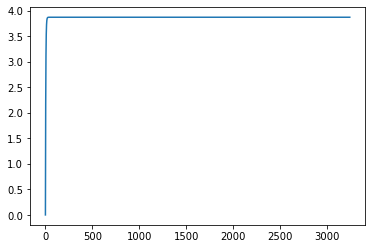

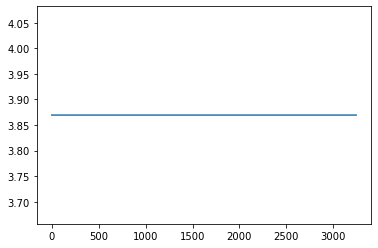

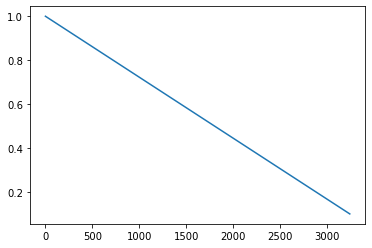

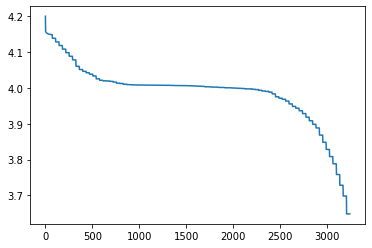

In [308]:
#for i in range(0, 5000):
    

def discrete_test():
    dbcell.reset()

    dt = 1/3600 # 1.0 seconds

    currents = []
    socs = []
    ocvs = []
    Irs = []
    i = 0
    while(dbcell.z > .1):
#         if(i < 1000):
#             c = np.random.uniform(0.0, 1.0)
#         elif(i >= 1000 and i <= 3000):
#             c = np.random.uniform(1.0, 2.0)
#         elif(i >= 3000 and i <= 6000):
#             c = np.random.uniform(2.8, 3.2)
#         else:
#             c = np.random.uniform(1.8, 2.2)
        currents.append(c)
        socs.append(dbcell.z)
        ocvs.append(dbcell.ocv)
        Irs.append(dbcell.Ir)
        dbcell.step(1, c)
        i += 1
    print(cbcell.z)
    print(i)
    plt.plot(Irs)
    plt.show()
    plt.plot(currents)
    plt.show()
    plt.plot(socs)
    plt.show()
    plt.plot(ocvs)
    plt.show()
    return ocvs
docvs = discrete_test()

0.09978291666729
3245


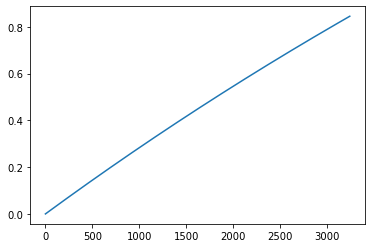

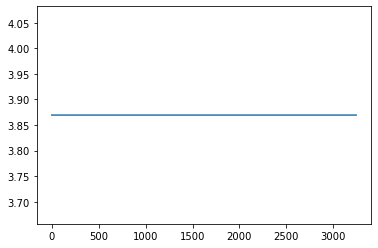

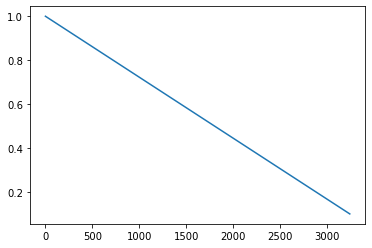

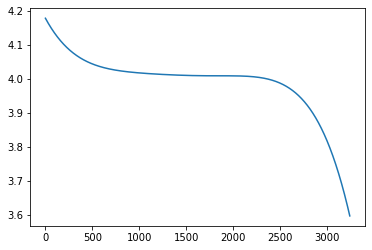

In [309]:
def continuous_test():
    cbcell.reset()

    dt = 1/3600 # 1.0 seconds

    t1 = nsteps(dt)
    currents = []
    socs = []
    ocvs = []
    Irs = []
    i = 0
    while(cbcell.z > .1):
        c = 3.8695
    #     if(i < 1000):
    #         c = np.random.uniform(0.0, 1.0)
    #     elif(i >= 1000 and i <= 3000):
    #         c = np.random.uniform(1.0, 2.0)
    #     elif(i >= 3000 and i <= 6000):
    #         c = np.random.uniform(2.8, 3.2)
    #     else:
    #         c = np.random.uniform(1.8, 2.2)
        currents.append(c)
        socs.append(cbcell.z)
        ocvs.append(cbcell.get_ocv() - cbcell.R*cbcell.Ir - cbcell.R0*current)
        Irs.append(cbcell.Ir)
        dz = (1 - odeint(dzdt, 1.0, t1, args=(c,))[-1][0])
        di = odeint(didt, cbcell.Ir, t1, args=(c,))[-1]
        cbcell.Ir = di
        cbcell.z = cbcell.z - dz
        i += 1
    print(cbcell.z)
    print(i)
    plt.plot(Irs)
    plt.show()
    plt.plot(currents)
    plt.show()
    plt.plot(socs)
    plt.show()
    plt.plot(ocvs)
    plt.show()
    return ocvs
    
cocvs = continuous_test()

3245
3245


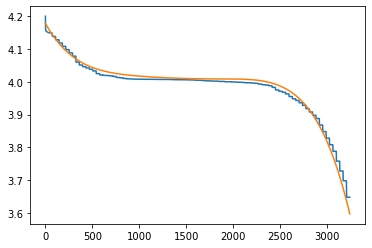

In [311]:
print(len(docvs))
print(len(cocvs))
plt.plot(docvs)
plt.plot(cocvs)
plt.show()

In [66]:
i = 0
while(cbcell.ocv > (cbcell.eod * 1.005)):
    cbcell.step(1, 3.8695)
    i += 1
print(cbcell.ocv)
print(i)

[3.05518742]
3556


In [231]:
vars(cbcell)

{'z_coef': array([[ 1.43512460e-09],
        [-4.33488147e-07],
        [ 5.21563505e-05],
        [-3.10719077e-03],
        [ 9.14558429e-02],
        [ 2.98893868e+00]]),
 'r0_coef': array([[ 1.09822958e-12],
        [-6.33382267e-10],
        [ 1.37942050e-07],
        [-1.26888097e-05],
        [ 4.51293118e-04],
        [-2.43713418e-03]]),
 'q_coef': array([[-6.44359504e-14],
        [ 4.66926421e-12],
        [-1.17626540e-08],
        [-3.24917358e-06],
        [-1.01950329e-03],
        [ 3.80005642e+00]]),
 'eol': 320,
 'soc': array([0.00194904]),
 'Ir': 3.869499999999999,
 'h': -0.9999999999999988,
 'M0': 0.0019,
 'M': 0.0092,
 'R0': 0.0112,
 'R': 0.000283,
 'Q': 3.8695,
 'n': 0.9987,
 'G': 163.4413,
 'v0': 4.2,
 'eod': 3.04,
 'RC': 3.6572,
 'ocv': 4.2}

### integration thru monte carlo simulation

In [ ]:
a = 0
b = np.pi
N = 1000
xrand = random.uniform(a, b, N)

def func(x):
    return np.sin(x)

I = 0.0

for i in range(N):
    I += func(xrand[i])
I = (b-a)/float(N)*I
print(I)

Iq = quad(func, a,b)[0]
print(Iq)